# Fitting $R_t$ From COVID-19 Infection Data

This notebook is intended to reproduce the `Realtime R0.ipynb` calculation closely, but producing a Bayesian posterior over the values of $R_t$ *and* $\sigma$ given the data instead of only fitting $R_t$ using a max-likelihood estimate for $\sigma$.  We employ a slightly different smoothing scheme (an exponential window with a decay rate of 7 days, to smooth out fluctuations on timescales shorter than (a) one week and (b) the serial timescale of the disease itself).  We use Stan to sample over the AR(1) prior for $R_t$ (increments are independent Gaussian variables) and also $\sigma$, the s.d. of the increment distribution.  Otherwise, the inference should be identical.  

The [Stan](http://mc-stan.org) model we use for the sampling can be found in the `R0.stan` file in the current directory.

Note that our Python environment is captured in `environment.yml`; issuing
```zsh
conda env create -f environment.yml
```
should duplicate it on your system.  You can then activate it via 
```zsh
conda activate covid-19
```

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [43]:
import arviz as az
import matplotlib.dates as md
import os
import os.path
import pandas as pd
import pystan
import seaborn as sns
from tqdm import tqdm

sns.set_context('notebook')
sns.set_palette('colorblind')

Download the latest data.

In [3]:
url = 'https://covidtracking.com/api/v1/states/daily.csv'
states = pd.read_csv(url,
                     usecols=['date', 'state', 'positive'],
                     parse_dates=['date'],
                     index_col=['state', 'date'],
                     squeeze=True).sort_index()

Compile the Stan model that simultaneously fits for $R_t$ and $\sigma$.

In [4]:
model = pystan.StanModel(file='R0.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_44dcf4810ed37e23473d639cfaac5f84 NOW.


## One State By Hand

Here we do my home state (NY) by hand, just to show aspects of the data processing, fitting, and plotting; stay tuned for the bulk run.

I chose to use an exponential filter with a 7-day time constant for smoothing instead of a Gaussian filter with a 2-day time-constant.  I think the 7-day constant is more appropriate for two reasons:
1. The amount of testing fluctuates between week and weekend (both because of supply and demand issues)
1. The serial time of the virus is ~7 days (assumed in the calculation below), so any given infected person is assumed able to infect others over 7 days.

This seems to eliminate the "oscillations" seen at http://rt.live (since it is smoothing on a longer timescale).

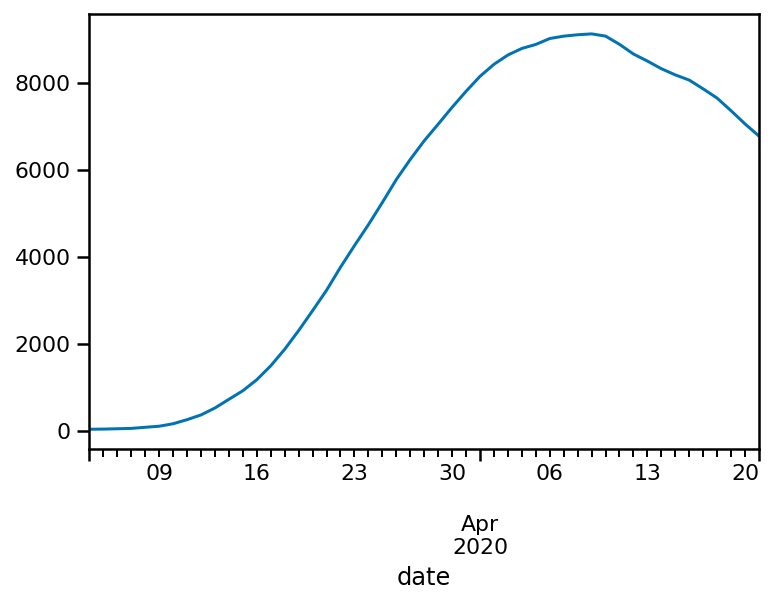

In [5]:
new_cases = states['NY'].diff()
smooth_new_cases = new_cases.rolling(20,
                                     win_type='exponential',
                                     min_periods=1,
                                     center=True).mean(tau=7).round()

smooth_new_cases.plot()

data = {
    'ndays': len(smooth_new_cases),
    'k': array(smooth_new_cases).astype(np.int),
    'lambda': 1.0/7.0 # serial time for one infectuous person.
}

Run the fits, hinting to `arviz` that it should use the appropriate date-time coordinates for the expected number of counts and $R_t$.

In [6]:
fit = az.from_pystan(model.sampling(data=data), 
                     coords={'exp_cts_dates': states['NY'].index,
                             'Rt_dates': states['NY'].index[1:]},
                     dims={'exp_cts': ['exp_cts_dates'],
                           'Rt': ['Rt_dates']})

A quick traceplot, just because it looks pretty:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x122063d50>,
      dtype=object)

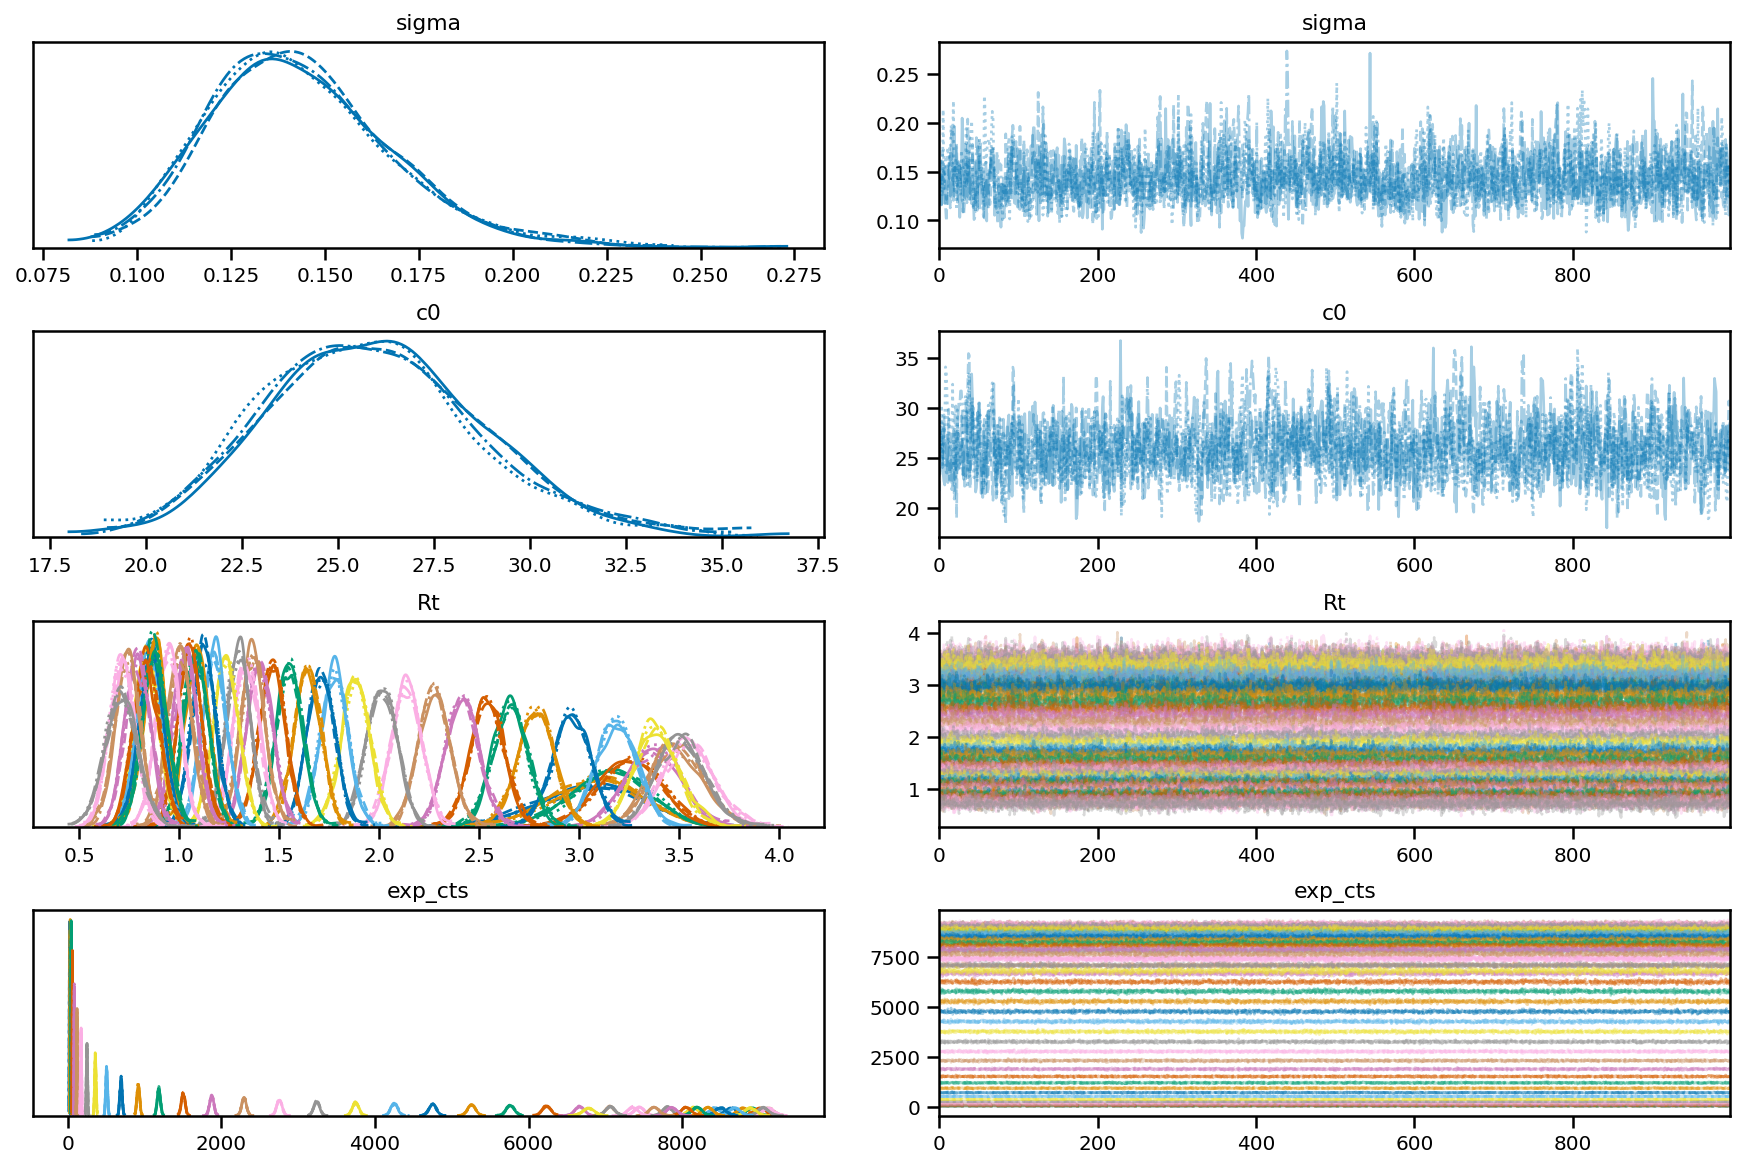

In [7]:
az.plot_trace(fit, compact=True)

In [8]:
print(az.summary(fit))
az.ess(fit).min()

                 mean      sd    hpd_3%   hpd_97%  mcse_mean  mcse_sd  \
sigma           0.144   0.024     0.099     0.187      0.001    0.000   
c0             25.931   2.806    20.903    31.216      0.077    0.055   
Rt[0]           3.061   0.262     2.554     3.522      0.007    0.005   
Rt[1]           3.087   0.226     2.674     3.515      0.006    0.004   
Rt[2]           3.155   0.191     2.794     3.508      0.005    0.004   
...               ...     ...       ...       ...        ...      ...   
exp_cts[44]  7865.971  64.228  7742.259  7979.857      0.802    0.568   
exp_cts[45]  7636.308  63.258  7514.527  7753.081      0.868    0.614   
exp_cts[46]  7358.732  63.745  7246.920  7487.798      0.939    0.664   
exp_cts[47]  7064.546  60.100  6949.088  7176.807      0.802    0.567   
exp_cts[48]  6779.035  74.307  6639.962  6920.650      0.986    0.697   

             ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
sigma          1383.0  1383.0    1390.0    2490.0    1.0  
c0   

<xarray.Dataset>
Dimensions:  ()
Data variables:
    sigma    float64 1.39e+03
    c0       float64 1.371e+03
    Rt       float64 1.322e+03
    exp_cts  float64 1.371e+03

Text(0, 0.5, '$R_t$')

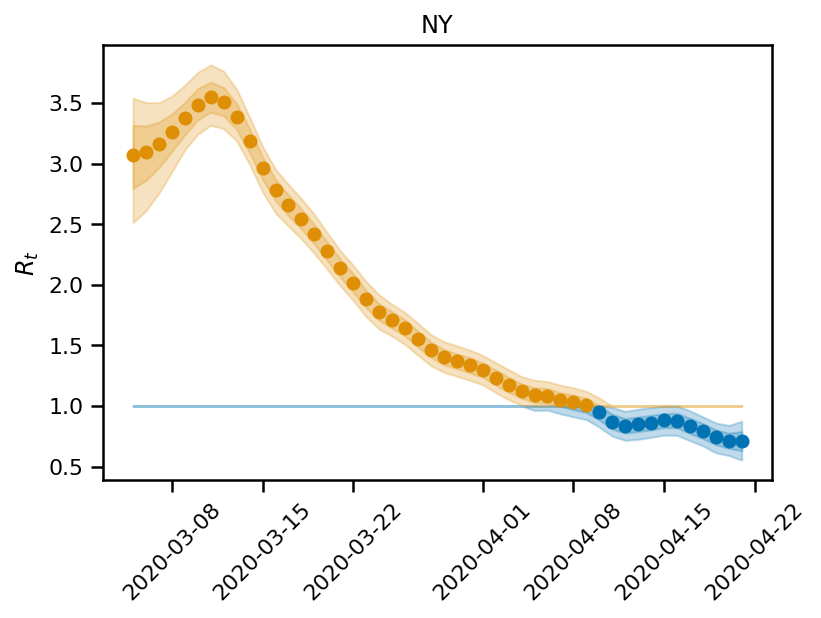

In [13]:
m = median(fit.posterior.Rt, axis=(0,1))
hh = percentile(fit.posterior.Rt, 97.5, axis=(0,1))
h = percentile(fit.posterior.Rt, 84, axis=(0,1))
l = percentile(fit.posterior.Rt, 16, axis=(0,1))
ll = percentile(fit.posterior.Rt, 2.5, axis=(0,1))

x = fit.posterior.Rt_dates.values

good_dates = m <= 1.0
bad_dates = m > 1.0

plot_date(x[good_dates], m[good_dates], xdate=True, color=sns.color_palette()[0])
fill_between(x, where(h<1, h, 1) , where(l<1, l, 1), alpha=0.25, color=sns.color_palette()[0])
fill_between(x, where(hh<1, hh, 1) , where(ll<1, ll, 1), alpha=0.25, color=sns.color_palette()[0])

plot_date(x[bad_dates], m[bad_dates], xdate=True, color=sns.color_palette()[1])
fill_between(x, where(h>1, h, 1) , where(l>1, l, 1), alpha=0.25, color=sns.color_palette()[1])
fill_between(x, where(hh>1, hh, 1) , where(ll>1, ll, 1), alpha=0.25, color=sns.color_palette()[1])

title('NY')

xticks(rotation=45)
ylabel(r'$R_t$')

## All States

In [5]:
def fit_state(states, state_key):
    new_cases = states[state_key].diff()
    smooth_new_cases = new_cases.rolling(20,
                                         win_type='exponential',
                                         min_periods=1,
                                         center=True).mean(tau=7).round()

    data = {
        'ndays': len(smooth_new_cases),
        'k': array(smooth_new_cases).astype(np.int),
        'lambda': 1.0/7.0 # serial time for one infectuous person.
    }
    
    fit = az.from_pystan(model.sampling(data=data), 
                         coords={'exp_cts_dates': states[state_key].index,
                                 'Rt_dates': states[state_key].index[1:]},
                         dims={'exp_cts': ['exp_cts_dates'],
                               'Rt': ['Rt_dates']})
    
    return fit

We run the fit on each state (takes about five minutes on my MacBook); some states have no data, so we skip those.  The fits may be marginal on some states (see warnings about E-BFMI) because the parameterization of the model is pretty basic (in the absence of a lot of testing---as in, say NY---the model falls back on the prior, and that generates a lot of correlation between $R_t$ values by design, which the sampler struggles with; re-parameterizing in terms of the *change* in $R_t$ from day to day would be better in these cases).

In [22]:
state_fits = {}
with tqdm(states.groupby(level=0)) as bar:
    for st, _ in bar.iterable:
        if np.all(np.isnan(states[st]) | (states[st] == 0)):
            bar.write('Skipping state: {:s}'.format(st))
            bar.update(1)
            continue
        state_fits[st] = fit_state(states, st)
        bar.update(1)

  5%|▌         | 3/56 [00:12<03:26,  3.89s/it]

Skipping state: AS


100%|██████████| 56/56 [05:22<00:00,  5.77s/it]


Save all the fits; use `load_state_fits` (untested) to load them back in.

In [26]:
def save_state_fits(fits, directory):
    try:
        os.makedirs(directory)
    except OSError:
        pass
    
    for k, f in fits.items():
        az.to_netcdf(f, os.path.join(directory, k + '.nc'))
def load_state_fits(directory):
    fits = {}
    for f in glob.glob(os.path.join(directory, '*.nc')):
        k = os.path.splitext(os.path.split(f)[1])[0]
        fits[k] = az.from_netcdf(f)

In [27]:
save_state_fits(state_fits, 'state_fits')

And make a plot that is similar to the one at http://rt.live

In [ ]:
strftime()

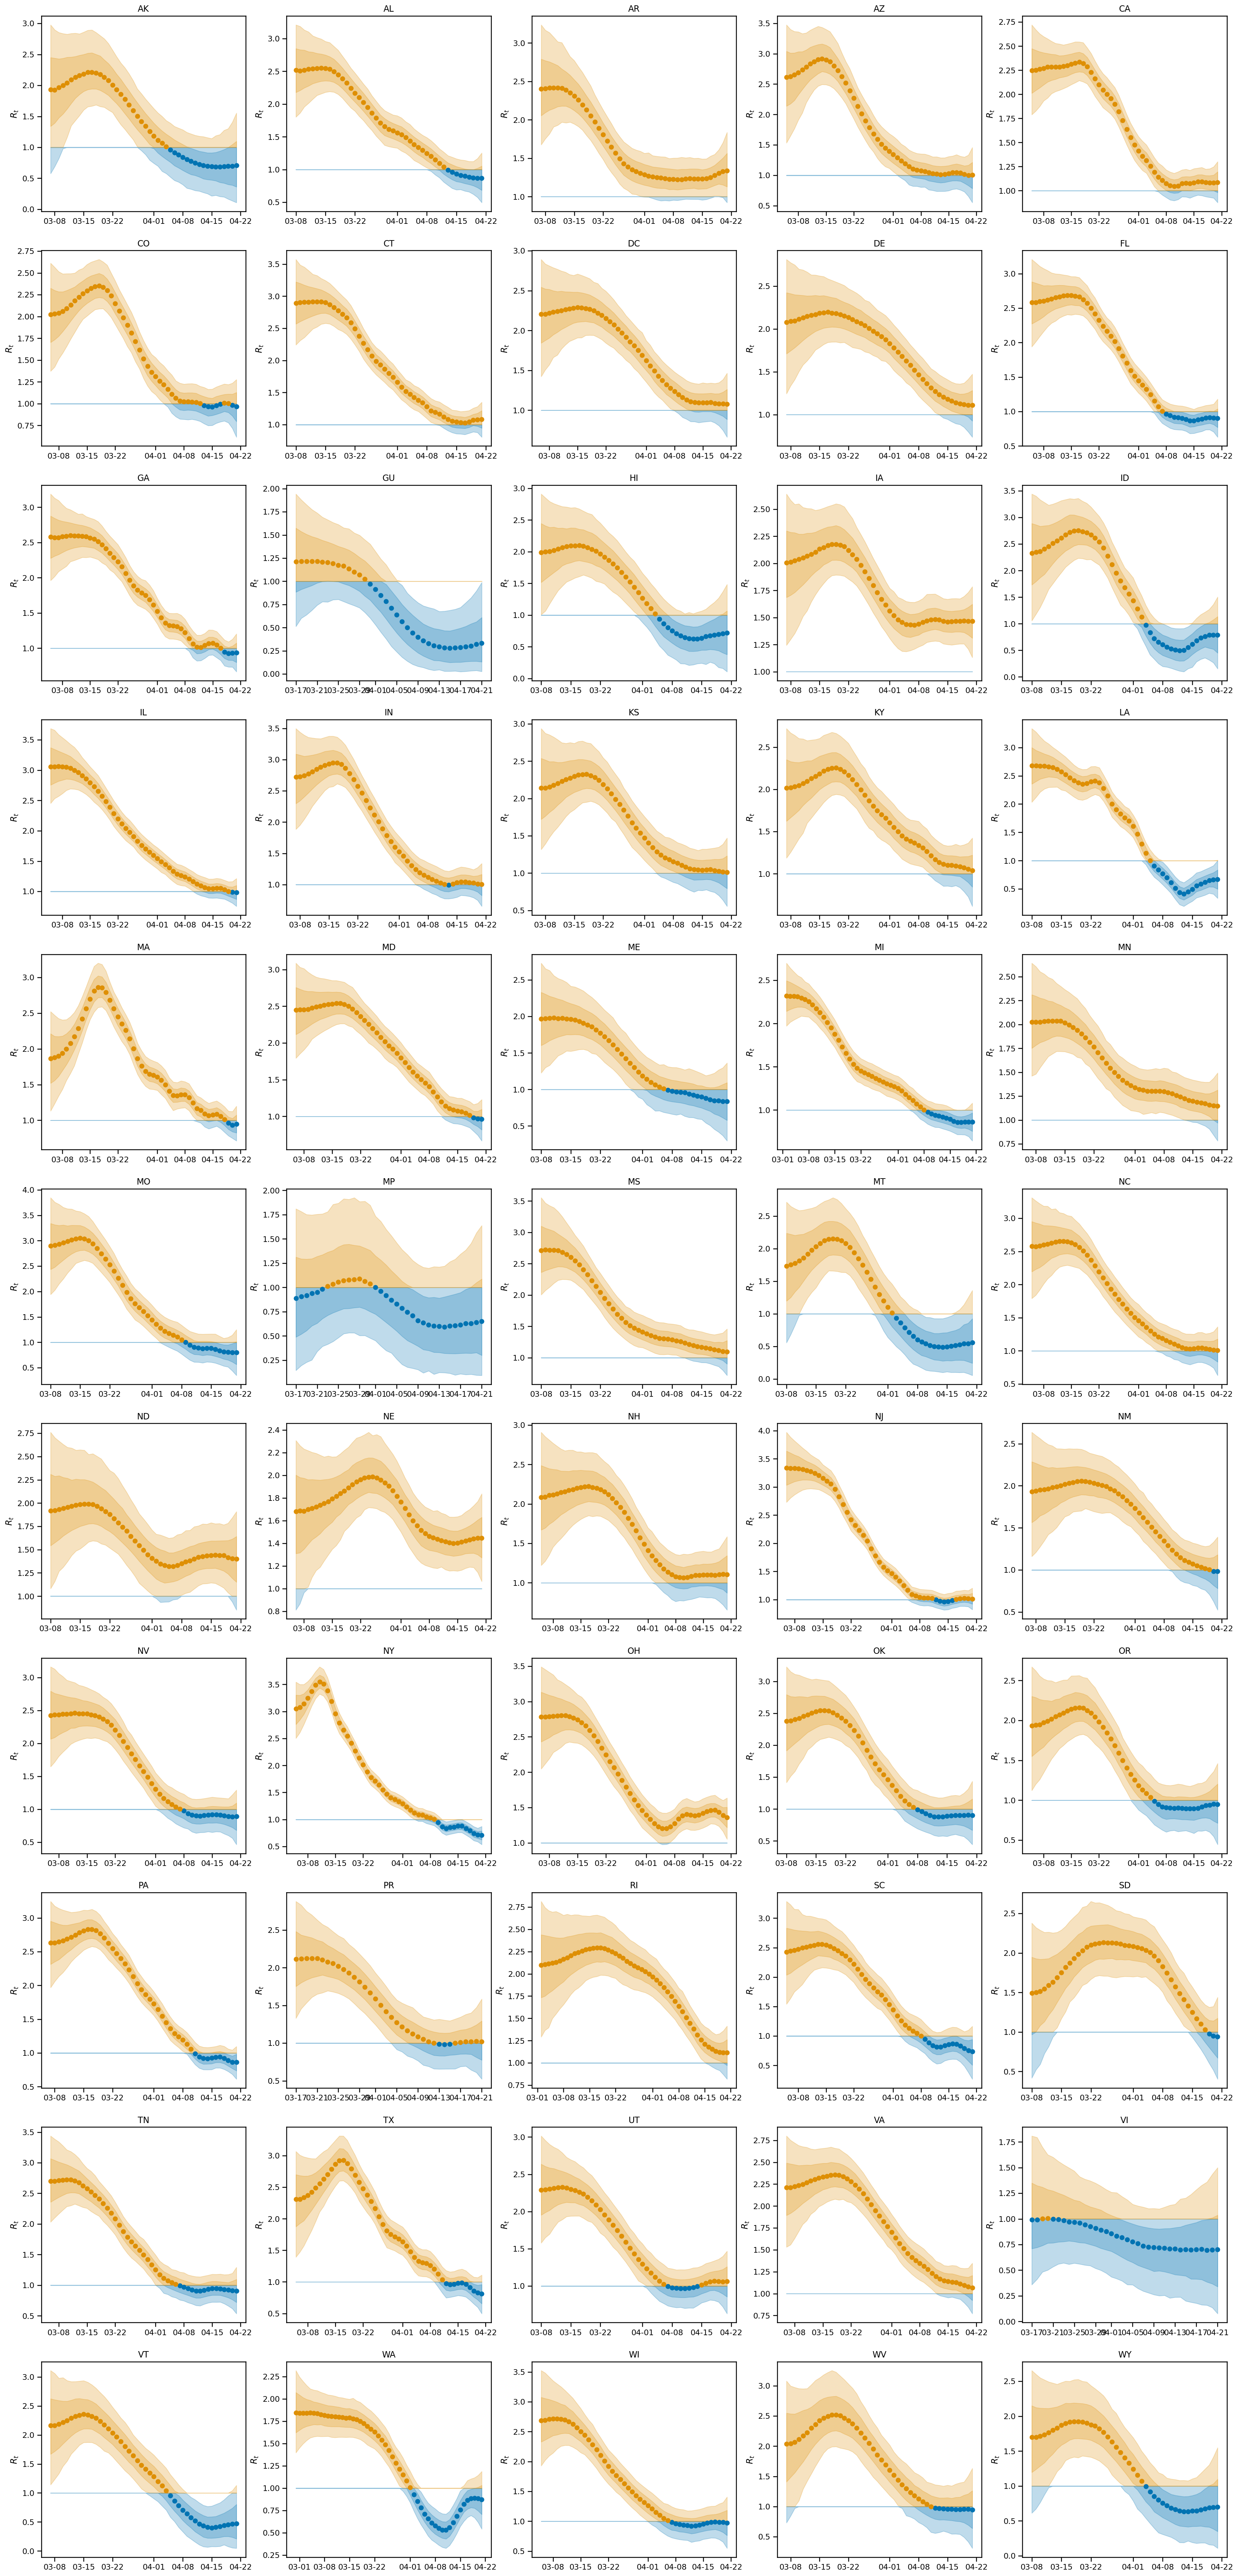

In [45]:
nc = 5
nr = 11

fig, axes = subplots(nrows=nr, ncols=nc, figsize=(30, 66))

for (k,fit), ax in zip(state_fits.items(), axes.flatten()):
    m = median(fit.posterior.Rt, axis=(0,1))
    hh = percentile(fit.posterior.Rt, 97.5, axis=(0,1))
    h = percentile(fit.posterior.Rt, 84, axis=(0,1))
    l = percentile(fit.posterior.Rt, 16, axis=(0,1))
    ll = percentile(fit.posterior.Rt, 2.5, axis=(0,1))

    x = fit.posterior.Rt_dates.values

    good_dates = m <= 1.0
    bad_dates = m > 1.0

    ax.plot_date(x[good_dates], m[good_dates], xdate=True, color=sns.color_palette()[0])
    ax.fill_between(x, where(h<1, h, 1) , where(l<1, l, 1), alpha=0.25, color=sns.color_palette()[0])
    ax.fill_between(x, where(hh<1, hh, 1) , where(ll<1, ll, 1), alpha=0.25, color=sns.color_palette()[0])

    ax.plot_date(x[bad_dates], m[bad_dates], xdate=True, color=sns.color_palette()[1])
    ax.fill_between(x, where(h>1, h, 1) , where(l>1, l, 1), alpha=0.25, color=sns.color_palette()[1])
    ax.fill_between(x, where(hh>1, hh, 1) , where(ll>1, ll, 1), alpha=0.25, color=sns.color_palette()[1])

    date_fmt = md.DateFormatter('%m-%d')
    ax.xaxis.set_major_formatter(date_fmt)
    
    ax.set_title(k)
    ax.set_ylabel(r'$R_t$')

Here is a nice plot that shows the distribution of $R_t$ at the latest day of sampling, ordered by its median value:

In [68]:
nc = 4
nd = 1000

d = {'state': [], 'Rt': []}
for k, f in state_fits.items():
    d = {'state': concatenate((d['state'], (k,)*(nc*nd))), 'Rt': concatenate((d['Rt'], f.posterior.Rt[:,:,-1].values.flatten()))}
df = pd.DataFrame(d)

med_Rts = [fit.posterior.Rt[:,:,-1].median() for fit in state_fits.values()]
state_order = array(list(state_fits.keys()))[argsort(med_Rts)]

Comparing to today's plot at http://rt.live, it looks like the exponential smoothing really influences the results:

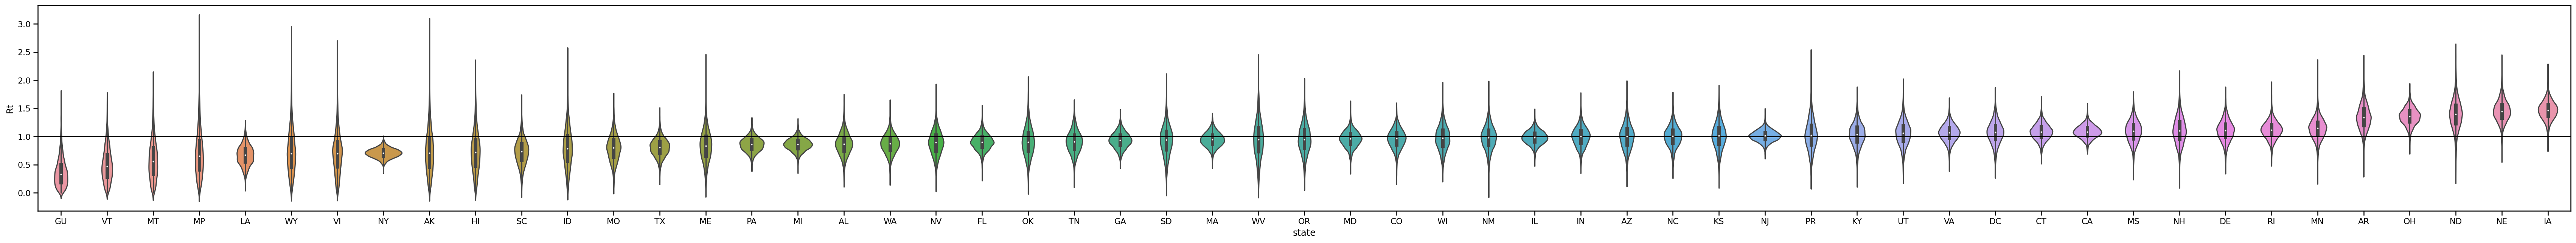

In [77]:
figure(figsize=(60, 5))
sns.violinplot(x='state', y='Rt', data=df, order=state_order)
axhline(1, color='k')

For example, the best state today at http://rt.live is Idaho, with $R_t$ = 0.19 (as of 2020-04-20), but I find:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x138df2c90>],
      dtype=object)

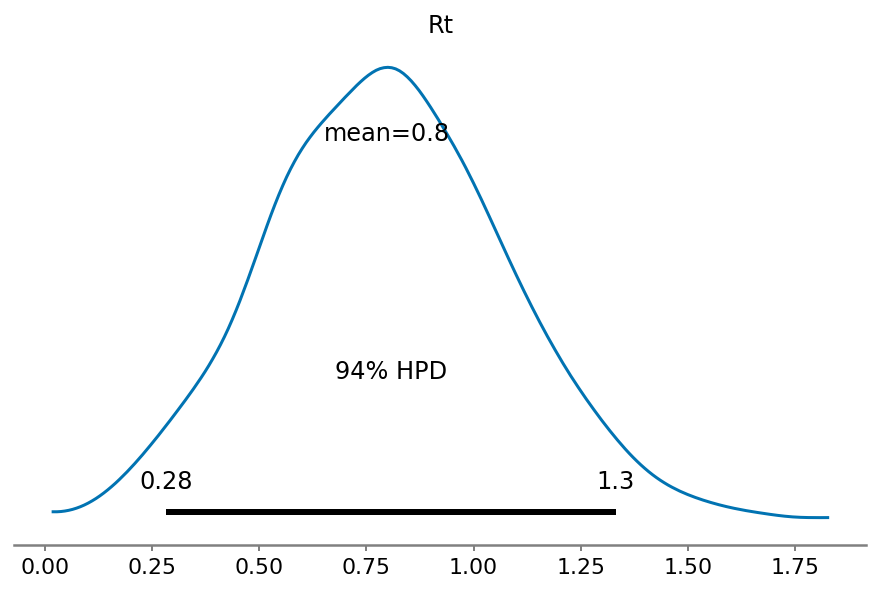

In [84]:
az.plot_posterior(state_fits['ID'], var_names='Rt', coords={'Rt_dates': np.datetime64('2020-04-20')})